In [1]:
import numpy as np

import matplotlib.pyplot as plt
import seaborn
% matplotlib inline

import pandas as pd

### Load

In [2]:
# ## Load if needed 
df_xy1 = pd.read_csv('./../../data/processed/20190712_x0_depce_test_full.csv')
df_xy2 = pd.read_csv('./../../data/processed/20190712_x0_depce_test_full2.csv')
df_xy3 = pd.read_csv('./../../data/processed/20190712_x0_depce_test_full3.csv')
df_xy = pd.concat([df_xy1, df_xy2, df_xy3], axis = 0)

# scale up
df_xy['var_qi'] = df_xy['var_qi']/(df_xy.s)**2
df_xy['y'] = df_xy['y']/(df_xy.s)**2
df_xy['x0'] = df_xy['x0']/(df_xy.s)**2

In [3]:
# fits are already saved scaled
fits1 = pd.read_csv('./../../data/processed/20190712_x0_depce_test_full_fits1.csv')
fits2 = pd.read_csv('./../../data/processed/20190712_x0_depce_test_full_fits2.csv')

fits1['pct'] = (fits1['q'] + .5)/fits1['Q']

## Analysis

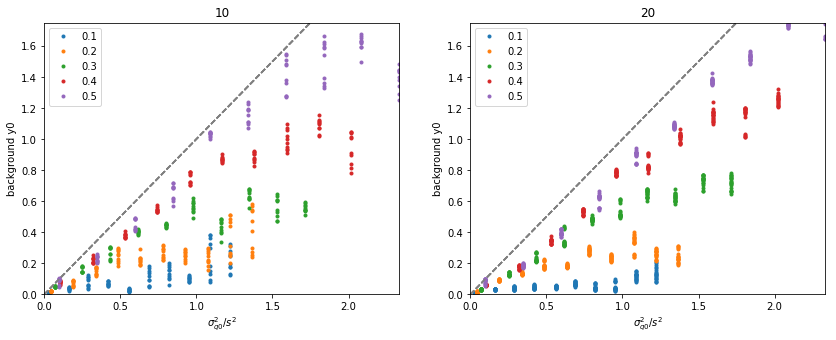

In [4]:
# # Dependence with Q and s

df_ = fits1.loc[fits1.dist == 'lapl']
# df_ = df_.loc[abs(df_.pct - .5) <= .25] # the middle qs are more robust in the x0 value

Q_list = [10, 20]
fig, axs = plt.subplots(1, 2, figsize = (7 * len(Q_list), 5))
for i, Q_ in enumerate(Q_list):
    df_Q = df_.loc[df_.Q == Q_]#
    ax = axs[i]    
    ax.set_title(str(Q_))#+', '+str(s_))
    for s_ in df_.s.unique():
        df_Qs = df_Q.loc[df_Q.s == s_]#
        
        df_Qs.plot('x0', 's0', marker = '.', lw = 0, ax = ax, label = str(s_))
        ym = 1.75
        ax.plot( [0,ym],[0,ym] , color = '.5', linestyle = '--')
        ax.set_xlabel(r'$\sigma^2_{q0}/s^2$')
        ax.set_ylabel('background y0')
        ax.legend()
#         ax.set_xlim(0, 0.025)
        ax.set_ylim(0, ym)

plt.show()
    
# Total var ( the 'y') should not change with Q.
# In the simple gaussian case, and with small volatility of q's we see a linear dependence that points to zero.

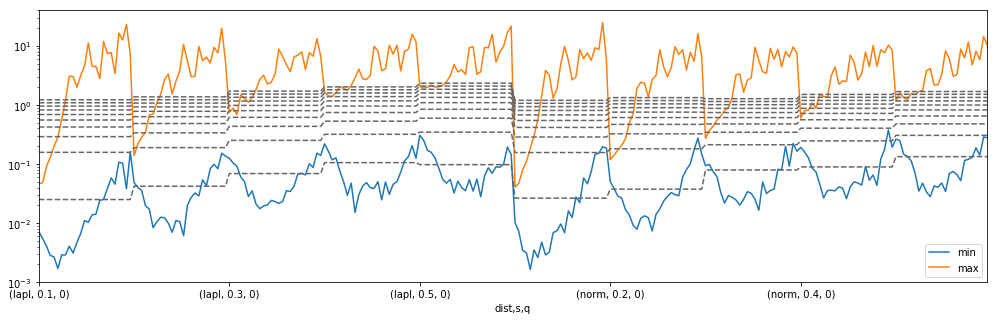

In [5]:
# Attention. We want x0 values to be comfortably reachable. Otherwise I will just be having them clipped for some of the Q, s, q combinations.

values_check = df_xy.reset_index(drop = True).drop(['y', 'x0'], axis = 1).drop_duplicates().sort_values(by = ['q', 'var_qi'])
# grouped = values_check.loc[(values_check.dist == 'norm')].groupby(['Q', 's', 'q'])
grouped = values_check.groupby(['dist','s', 'q'])

fig, ax = plt.subplots(1, figsize = (17, 5))
grouped.agg(['min', 'max'])['var_qi'].plot(ax = ax)
# ax.axhline(0.01)
# ax.axhline(0.02)
# ax.set_ylim(0, 0.03)
ax.set_yscale('log')

s_dist_grouped = grouped.agg(['min', 'max'])['var_qi'].groupby(level = [0, 1])
x0_s_dist = pd.concat([s_dist_grouped['min'].quantile(.7) + \
           l*(s_dist_grouped['max'].quantile(.3) - s_dist_grouped['min'].quantile(.7)) for l in np.arange(0, 1, .1)], axis = 1).round(4)

df_ = grouped.agg(['min', 'max'])['var_qi'].reset_index().merge(x0_s_dist.reset_index()).set_index(['dist', 's', 'q'])

df_[range(10)].plot(color = '.4', linestyle = '--', ax = ax, legend=False)

plt.show()

[ 0.759 -0.003]
[ 0.807 -0.031]
[ 0.757 -0.014]


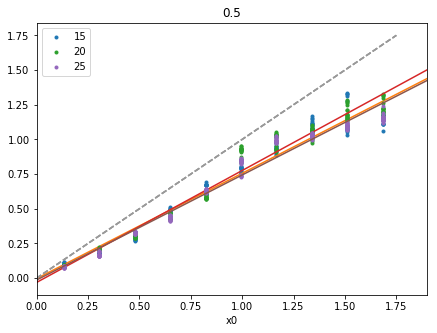

In [6]:
df_ = fits1.loc[fits1.dist == 'norm']
# df_ = df_.loc[abs(df_.pct - .5) <= .25] # the middle qs are more robust in the x0 value

## Dependence with Q

fig, ax = plt.subplots(1, figsize = (7, 5))
aQ = []
for Q_ in [15, 20, 25]:
    s_ = .5
    ax.set_title(str(s_))
    data = df_.loc[(df_.Q == Q_) & (df_.s == s_)]
    data.plot('x0', 's0', marker = '.', lw = 0, ax = ax, label = str(Q_))
    
    line = np.polyfit(data.x0, data.s0, 1)
    ax.plot(np.arange(0, 2, 0.1), np.arange(0, 2, 0.1)*line[0] + line[1])
    
    ym = 1.75
    ax.plot( [0,ym],[0,ym] , color = '.6', linestyle = '--')
        
        
    print(line.round(3))
    # This is useful for a(Q). For now not a clearly explainable dependence
    aQ += [line[0]]
aQ = np.array(aQ)
# ax.set_xlim(0, 0.025)
# ax.set_ylim(0, 0.04)
ax.legend()
plt.show()

### The s0 terms

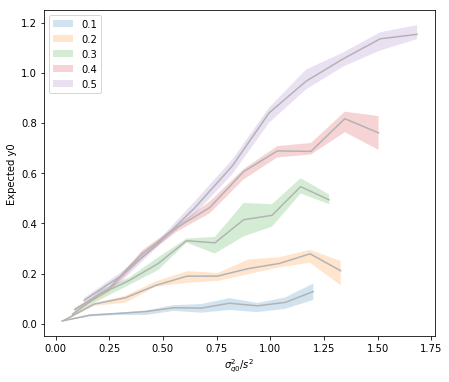

In [14]:
s0_describe = fits1.groupby(['dist', 's', 'x0'])['s0'].describe() # does not depend on Q

s0_describe = s0_describe[['75%', 'mean', '25%']]

fig, ax = plt.subplots(1, figsize = (7,6))
for s_ in s0_describe.index.get_level_values('s').unique():
    data = s0_describe.loc['norm'].loc[s_].reset_index()
    ax.fill_between(data.x0, data['25%'], data['75%'], alpha = .2, label = str(s_))
    ax.plot(data.x0, data['mean'], color = '.7', label = '_')
ax.set_xlabel(r'$\sigma^2_{q0}/s^2$')
ax.set_ylabel('Expected y0')
ax.legend()
plt.show()

#### Partial derivatives at x0

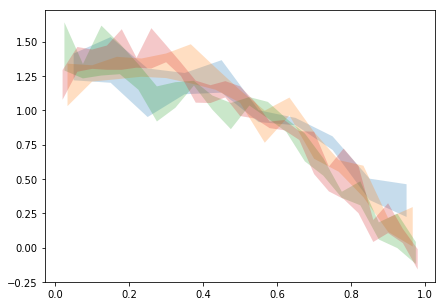

In [7]:
fits2['part_dev_x0'] = 2 * fits2.a * fits2.x0 + fits2.b
df_ = fits2.set_index(['dist']).loc['norm']

part_devs_q = df_.loc[df_.s == .5].groupby(['Q', 'q'])['part_dev_x0'].describe()[['mean', '25%','50%','75%']]
part_devs_q = part_devs_q.reset_index()
part_devs_q['pct'] = (part_devs_q['q'] + .5)/part_devs_q['Q']

fig, ax = plt.subplots(1, figsize = (7, 5))
for Q_ in part_devs_q.Q.unique():
    data = part_devs_q.loc[part_devs_q.Q == Q_]
    ax.fill_between(data.pct, Q_*data['25%'], Q_*data['75%'], alpha = .25)
plt.show()
# High q are the little populated, volatile ones.

### The $(\sigma^2_q - \sigma^2_0)$ term
Computed as difference between median and x0. It is just to have a qualitative idea, cause actually $\sigma^2_q$ will be given in each custom case

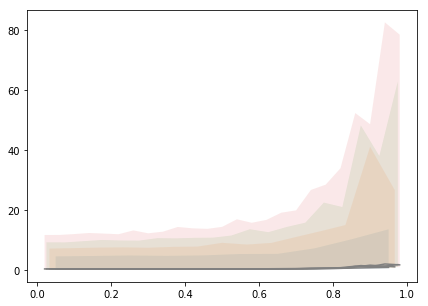

In [152]:
# describe var_qi by dist, Q, q, s (s = .3 for now)
describe = df_xy.loc[df_xy.s == .4].drop(['y','x0'], axis = 1).drop_duplicates().groupby(['dist','Q','q','s'])['var_qi'].describe()
describe = describe.loc['lapl']

describe = describe.reset_index()
describe['pct'] = (describe['q'] + .5)/describe['Q']

fig, ax = plt.subplots(1, figsize = (7, 5))
for Q_ in describe.Q.unique():
    data = describe.loc[describe.Q == Q_]
    ax.fill_between(data.pct, data['25%'], Q_*data['75%'], alpha = .1)
    ax.plot(data.pct, data['50%'], color = '.5')
plt.yscale('log')
# plt.ylim(0, 0.2)
plt.show()


## A term: $\frac{\partial \sigma^2}{\partial \sigma^2_q} (\sigma^2_q - \sigma^2_0) $

We use as x_0 = 0.02 as it is a quite good approx for all the pcts in the lower part of value.

In [9]:
# describe var_qi by dist, Q, q, s (s = .3 for now)

s_ = .4
df_ = df_xy.loc[(df_xy.s == s_) & (df_xy.dist == 'norm')]
x0_ = df_.x0.unique()[5]
df_ = df_.loc[df_.x0 == x0_]

# df_ = df_xy.loc[df_xy.s == .4].drop(['x0'], axis = 1).drop_duplicates()
describe_var_q = df_.groupby(['dist','Q','q','s'])[['var_qi', 'y']].describe()

df_ = fits2.loc[(fits2.s == s_) & (fits2.dist == 'norm')]
describe_part_dev_x0 = df_.groupby(['dist','Q', 'q', 's'])[['part_dev_x0']].describe()

describe = pd.concat([describe_var_q, describe_part_dev_x0], axis = 1)
describe = describe.iloc[:, describe.columns.get_level_values(1).isin(['25%','50%','75%'])]

describe = describe.reset_index()
describe['pct'] = (describe['q'] + .5)/describe['Q']

/home/miglesia/anaconda2/envs/my_pymc_env/lib/python3.6/site-packages/pandas/core/generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


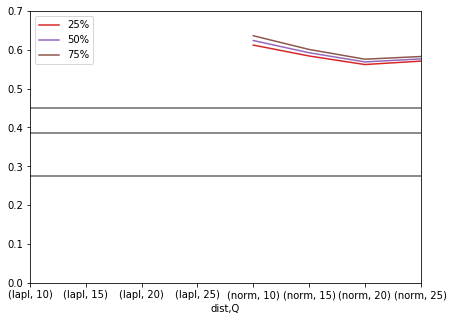

In [158]:
# I'm trying to reconstruct the y from a sum for all q of  ds/dsq .(sq - s0)

fig, ax = plt.subplots(1, figsize = (7, 5))
for i, Q_ in enumerate([10, 15, 25]):
    y0 = aQ[i] * x0_
    df_ = describe.loc[(describe.dist == 'norm') & (describe.Q == Q_)]
    # Evaluated at the medians:
    yq = Q_ * df_['part_dev_x0']['50%'] * (df_['var_qi']['50%'] - x0_)
    yq = df_['part_dev_x0']['50%'] * (df_['var_qi']['50%'] - x0_)
    ax.plot(df_.pct, yq, marker = '.')
    ax.axhline(y0 , color = '.4')

describe.groupby(['dist', 'Q']).mean()['y'].plot(ax = ax) # Should be always the same value...
plt.ylim(0, 0.7)

plt.show()
# It doesn quite work at the median... may be because, eg. in the median case all (x-x0) are positive, while 
# in particular cases they will be on both sides, therefor counteracting.

### xq are medians

AttributeError: 'DataFrame' object has no attribute 'dist'

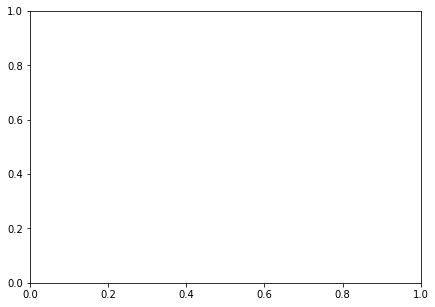

In [787]:
# I'm trying to reconstruct the y from a sum for all q of  ds/dsq .(sq - s0)

fig, ax = plt.subplots(1, figsize = (7, 5))
for i, Q_ in enumerate([10, 15, 25]):
    y0 = aQ[i] * x0_
    df_ = describe.loc[(describe.dist == 'norm') & (describe.Q == Q_)]
    # Evaluated at the medians:
    yq = Q_ * df_['part_dev_x0']['50%'] * (df_['var_qi']['50%'] - 0.019)
    yq = df_['part_dev_x0']['50%'] * (df_['var_qi']['50%'] - x0_)
    ax.plot(df_.pct, yq, marker = '.')
    ax.axhline(y0 , color = '.4')

describe.groupby(['dist', 'Q']).mean()['y'].plot(ax = ax) # Should be always the same value...
# plt.ylim(0, 0.02)

plt.show()
# It doesn quite work at the median... may be because, eg. in the median case all (x-x0) are positive, while 
# in particular cases they will be on both sides, therefor counteracting.

### xq are the xqi

In [ ]:
def parabola(x, a, b, c):
    return a*x**2 + b*x + c

In [151]:
# # debug random parabola fits

# for i, row in df_xy[['dist', 's', 'x0', 'Q', 'q']].drop_duplicates().sample(5).iterrows():
#     print(row)
#     dist, s, x0, Q, q = tuple(row)
#     fit_pars = fits2.loc[(fits2.dist == dist) & (fits2.s == s) & (fits2.x0 == x0) & (fits2.Q == Q) & (fits2.q == q)]
#     points = df_xy.loc[(df_xy.dist == dist) & (df_xy.s == s) & (df_xy.x0 == x0) & (df_xy.Q == Q) & (df_xy.q == q)]

#     x = np.arange(0, 1, .1)
#     y = parabola(x, *tuple(fit_pars[['a', 'b', 'c']].values[0]))


#     plt.scatter(points.var_qi, points.y, marker = '.', alpha = .3)
#     plt.plot(x, y, color = 'r')
#     plt.xlim(0, 1)
#     plt.ylim(0, 1)
#     plt.show()

In [27]:
# plt.scatter(x = fits2['s0'].values, y = fits1['s0'].values, marker = '.')
# plt.show()
# fits2['s0'].values
# Its quite the same except when the parabolas go crazy.

In [159]:
fits1['part_dev_x0'] = fits1.a

# fits2['part_dev_x0'] = 2 * fits2.a * fits2.x0 + fits2.b
# fits2['s0'] = fits1.s0 # a * fits2.x0**2 + fits2.b * fits2.x0 + fits2.c
# fits2.loc[(fits2.dist == 'norm') & (fits2.s == .4)].sort_values(by = ['q','Q', 's','dist','x0'])
# fits2

# For t - t0 I need the df_xy here
# Hope this works, but it's not guaranteed
df_xy['i'] = np.array((10 + 15 + 20 + 25)*2*10*5*list(range(500)))

merged = df_xy.merge(fits1, on = ['dist', 's', 'x0', 'Q', 'q'])

merged['tqi - t0'] = merged['var_qi'] - merged['x0']
#

# Now make the columns that have the Q, q series terms...
merged['series_term_Qqi'] = merged['tqi - t0']*merged['part_dev_x0']

In [160]:
# merged.sort_values(by = 'series_term_Qqi', ascending = False)
result = merged.groupby(['dist', 's', 'Q', 'x0', 'i']).agg({'series_term_Qqi': 'sum', 'y': 'mean', 's0': 'mean'}).rename(columns = {'series_term_Qqi': 'series_term_Qq'})
result['Series_sum'] = result.series_term_Qq/result.index.get_level_values('Q') + result.s0


,var_qi,y,q,Q,s,dist,x0,i,a,b,s0,pct,part_dev_x0,tqi - t0,series_term_Qqi
525877,1.940297,0.427287,1,10,0.5,lapl,0.0976,377,0.182950,0.041770,0.059626,0.150000,0.182950,1.842697,0.337122
525232,1.761734,0.481108,0,10,0.5,lapl,0.0976,232,0.198429,0.026801,0.046168,0.050000,0.198429,1.664134,0.330213
525498,1.553790,0.384135,0,10,0.5,lapl,0.0976,498,0.198429,0.026801,0.046168,0.050000,0.198429,1.456190,0.288951
525940,1.626396,0.394295,1,10,0.5,lapl,0.0976,440,0.182950,0.041770,0.059626,0.150000,0.182950,1.528796,0.279693
2347966,3.618935,0.431191,10,15,0.5,lapl,0.0976,466,0.079143,0.077898,0.085622,0.700000,0.079143,3.521335,0.278689
525375,1.489889,0.339831,0,10,0.5,lapl,0.0976,375,0.198429,0.026801,0.046168,0.050000,0.198429,1.392289,0.276271
525624,1.592736,0.336305,1,10,0.5,lapl,0.0976,124,0.182950,0.041770,0.059626,0.150000,0.182950,1.495136,0.273535
526697,1.736766,0.471828,3,10,0.5,lapl,0.0976,197,0.165078,0.066982,0.083094,0.350000,0.165078,1.639166,0.270590
526969,1.661043,0.376048,3,10,0.5,lapl,0.0976,469,0.165078,0.066982,0.083094,0.350000,0.165078,1.563443,0.258090
525366,1.358769,0.302430,0,10,0.5,lapl,0.0976,366,0.198429,0.026801,0.046168,0.050000,0.198429,1.261169,0.250253


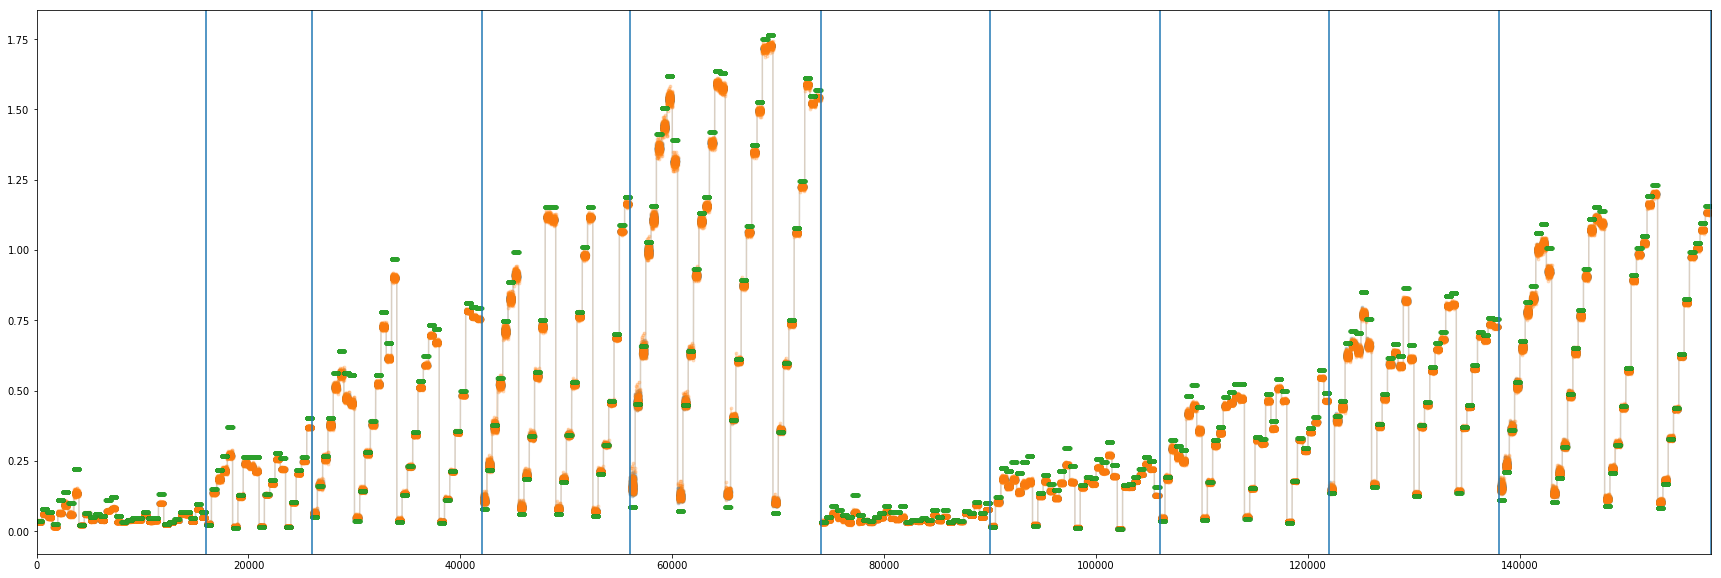

In [259]:

plt.figure(figsize = (30, 10))
result.reset_index()['Series_sum'].plot(marker = '.', alpha = .2)
result.reset_index()['y'].plot(marker = '.', alpha = .2)
result.reset_index()['s0'].plot(alpha = .2, lw = 0, marker = '.')

vals = result.groupby(level = [0, 1]).count().iloc[:, 0].cumsum().values
[plt.axvline(x)for x in vals]
plt.show()

In [252]:
result['o1_series'] = result.Series_sum - result.s0
result['solution'] = result.y - result.s0

In [246]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

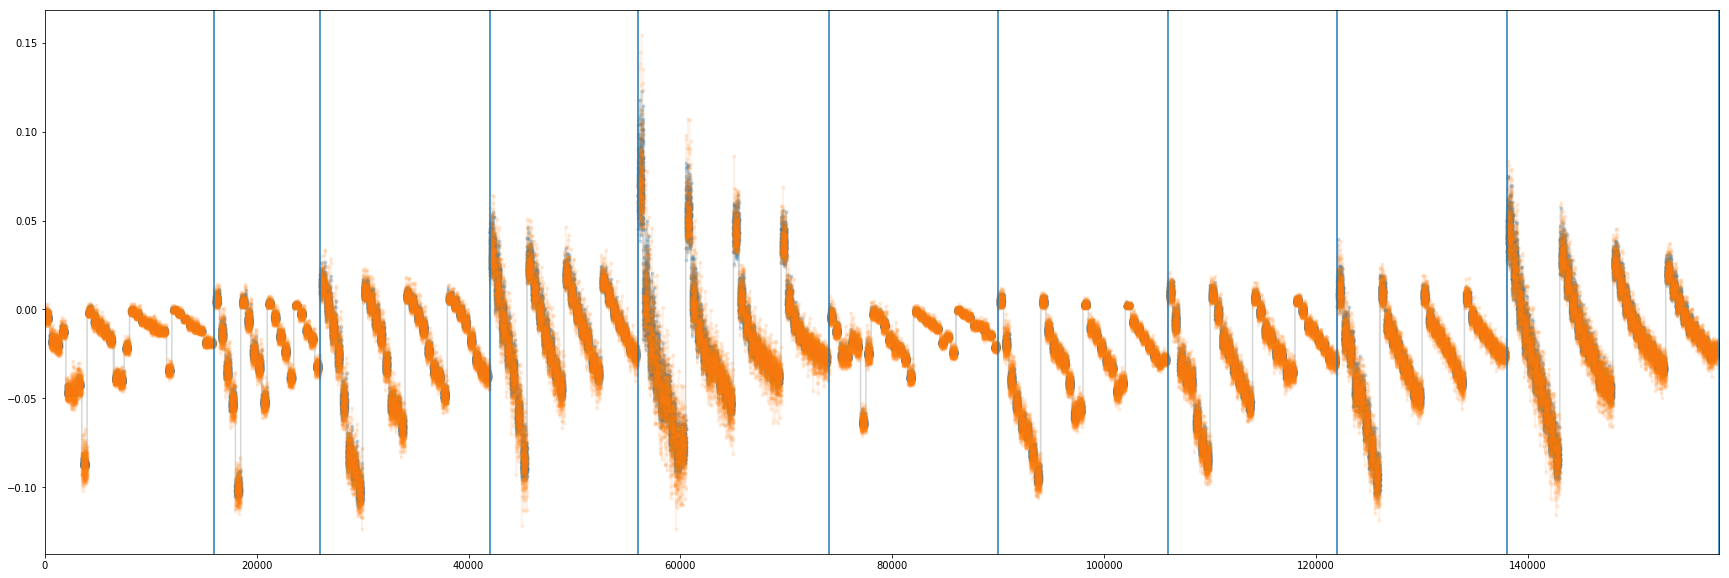

In [262]:
plt.figure(figsize = (30, 10))
result.reset_index()['o1_series'].plot(marker = '.', alpha = .2)
result.reset_index()['solution'].plot(marker = '.', alpha = .1)

vals = result.groupby(level = [0, 1]).count().iloc[:, 0].cumsum().values
[plt.axvline(x)for x in vals]
# ply.xlim()
# plt.ylim(-.1, .1)
plt.show()

In [218]:
result['error'] = (result.Series_sum -  result.y)
result['solution'] = (result.y - result.s0)

plt.figure(figsize = (30, 10))
result.reset_index()['Series_sum'].plot(marker = '.', alpha = .2)
result.reset_index()['solution'].plot(marker = '.', alpha = .2)

vals = result.groupby(level = [0, 1]).count().iloc[:, 0].cumsum().values
[plt.axvline(x)for x in vals]
# ply.xlim()
plt.ylim(-.1, .1)

series_term_Qq         y        s0  Series_sum  \
dist s   Q  x0     i                                                     
lapl 0.1 10 0.1600 0         -0.049124  0.032173  0.037027    0.032114   
                   1         -0.036476  0.035190  0.037027    0.033379   
                   2         -0.042663  0.034289  0.037027    0.032760   
                   3         -0.058102  0.030969  0.037027    0.031217   
                   4         -0.042951  0.035480  0.037027    0.032732   
                   5         -0.044617  0.032081  0.037027    0.032565   
                   6         -0.007460  0.030782  0.037027    0.036281   
                   7         -0.052357  0.032988  0.037027    0.031791   
                   8         -0.058352  0.029561  0.037027    0.031192   
                   9         -0.011645  0.038264  0.037027    0.035862   
                   10        -0.046463  0.032218  0.037027    0.032380   
                   11        -0.049516  0.033646  0.037027    0.032075   
                   12        -0.048999  0.032570  0.037027    0.032127   
                   13        -0.004257  0.031829  0.037027    0.036601   
                   14        -0.008289  0.036514  0.037027    0.036198   
                   15        -0.046647  0.033888  0.037027    0.032362   
                   16        -0.058837  0.029370  0.037027    0.031143   
                   17        -0.053329  0.033004  0.037027    0.031694   
                   18        -0.027145  0.032948  0.037027    0.034312   
                   19        -0.049423  0.031958  0.037027    0.032084   
                   20        -0.054767  0.032446  0.037027    0.031550   
                   21        -0.048049  0.031122  0.037027    0.032222   
                   22        -0.044304  0.029778  0.037027    0.032596   
                   23        -0.024219  0.036016  0.037027    0.034605   
                   24        -0.044964  0.035896  0.037027    0.032530   
                   25        -0.031394  0.032266  0.037027    0.033887   
                   26        -0.044617  0.033067  0.037027    0.032565   
                   27        -0.041280  0.031793  0.037027    0.032899   
                   28        -0.049721  0.033166  0.037027    0.032055   
                   29        -0.044176  0.032988  0.037027    0.032609   
...                                ...       ...       ...         ...   
norm 0.5 25 1.6832 470       -0.639514  1.128907  1.156579    1.092627   
                   471       -0.614970  1.130113  1.156579    1.095082   
                   472       -0.571972  1.135914  1.156579    1.099381   
                   473       -0.567226  1.133309  1.156579    1.099856   
                   474       -0.614119  1.134686  1.156579    1.095167   
                   475       -0.580521  1.133970  1.156579    1.098526   
                   476       -0.557896  1.134672  1.156579    1.100789   
                   477       -0.600720  1.134385  1.156579    1.096507   
                   478       -0.576919  1.130147  1.156579    1.098887   
                   479       -0.603209  1.136715  1.156579    1.096258   
                   480       -0.478638  1.139844  1.156579    1.108715   
                   481       -0.601915  1.131626  1.156579    1.096387   
                   482       -0.611325  1.130347  1.156579    1.095446   
                   483       -0.565658  1.136890  1.156579    1.100013   
                   484       -0.549759  1.132161  1.156579    1.101603   
                   485       -0.557634  1.130975  1.156579    1.100815   
                   486       -0.572351  1.135344  1.156579    1.099343   
                   487       -0.619022  1.134942  1.156579    1.094676   
                   488       -0.606301  1.129264  1.156579    1.095948   
                   489       -0.532453  1.135342  1.156579    1.103333   
                   490       -0.555819  1.134740  1.156579    1.100997   
                   491      

In [213]:
s_ = .4


for i, Q_ in enumerate([10, 15, 25]):
    y0 = aQ[i] * x0_
    df_ = describe.loc[(describe.dist == 'norm') & (describe.Q == Q_)]
    
    slice_ = df_xy.loc[(df_xy.s == s_) & (df_xy.dist == 'norm') & (df_xy.Q == Q_) & (df_xy.x0 == x0_)]
#     slice_ = slice_.reset_index()
    part_dev_x0 = df_.set_index(['dist', 'Q' , 's', 'q','pct'])['part_dev_x0']['50%'].reset_index().rename(columns = {'50%': 'part_dev_x0'})
# debug. See var_y values for all the i experiments.
# slice_.groupby('i')['y'].describe()[['25%','50%','75%']].plot()
    slice_ = slice_.merge(part_dev_x0)
    slice_['xqi - x0'] = slice_['var_qi'] - slice_['x0']
    slice_['y0'] = y0
    slice_['(x-x0)dy/dx'] = slice_['part_dev_x0']*slice_['xqi - x0']
    slice_ = slice_.sort_values(by = ['i', 'q'])


AttributeError: 'DataFrame' object has no attribute 'dist'

In [236]:
y0 = s0

75%      mean       25%
dist s   x0                                    
lapl 0.1 0.030000  0.010215  0.008583  0.006944
         0.160000  0.032680  0.028579  0.023269
         0.290000  0.060390  0.049042  0.032205
         0.420000  0.060535  0.049032  0.037802
         0.560000  0.067746  0.055208  0.046378
         0.690000  0.076324  0.071641  0.057399
         0.820000  0.094036  0.073214  0.035371
         0.950000  0.115850  0.088907  0.073706
         1.090000  0.150870  0.136282  0.099195
         1.220000  0.128637  0.106045  0.058922
     0.2 0.042500  0.017907  0.015352  0.012971
         0.190000  0.091154  0.080754  0.067369
         0.337500  0.134698  0.124425  0.111777
         0.485000  0.221264  0.203118  0.183681
         0.632500  0.248966  0.217625  0.190985
         0.780000  0.285437  0.269337  0.255216
         0.927500  0.300980  0.274043  0.246703
         1.075000  0.331342  0.262894  0.203594
         1.220000  0.402383  0.327244  0.256929
         1.367500  0.330183  0.288451  0.222165
     0.3 0.068889  0.037995  0.035338  0.030452
         0.251111  0.145456  0.130905  0.112195
         0.433333  0.273566  0.241499  0.214369
         0.616667  0.403135  0.370442  0.346674
         0.798889  0.495769  0.485681  0.468689
         0.981111  0.552787  0.530524  0.501418
         1.163333  0.666934  0.603063  0.563735
         1.345556  0.813281  0.726354  0.632931
         1.527778  0.775887  0.717912  0.664726
         1.711111  0.828534  0.775197  0.712096
...                     ...       ...       ...
norm 0.3 0.078889  0.041566  0.037684  0.031776
         0.212222  0.134583  0.119270  0.097769
         0.344444  0.185032  0.172871  0.154889
         0.477778  0.264530  0.239744  0.213500
         0.610000  0.339504  0.330711  0.322812
         0.742222  0.346003  0.322279  0.279671
         0.875556  0.481222  0.414377  0.348027
         1.007778  0.475940  0.431795  0.386611
         1.141111  0.580083  0.546217  0.519033
         1.273333  0.515190  0.493782  0.476785
     0.4 0.089375  0.063399  0.056988  0.048170
         0.246250  0.141461  0.137716  0.125741
         0.403750  0.292620  0.279986  0.261040
         0.560625  0.389172  0.380389  0.364877
         0.718125  0.487282  0.463089  0.440119
         0.875000  0.616229  0.605712  0.574489
         1.032500  0.707732  0.688557  0.662762
         1.189375  0.720188  0.686862  0.674359
         1.346875  0.845027  0.817053  0.763273
         1.503750  0.827391  0.760726  0.692954
     0.5 0.133600  0.103465  0.093261  0.083881
         0.305600  0.205370  0.190888  0.167333
         0.478000  0.330978  0.319869  0.309480
         0.650000  0.489299  0.463511  0.437864
         0.822400  0.653510  0.628001  0.595147
         0.994400  0.861220  0.840161  0.801022
         1.166800  1.013114  0.966662  0.934097
         1.338800  1.080705  1.055401  1.024682
         1.511200  1.161487  1.135277  1.088630
         1.683200  1.190216  1.153330  1.134120

[100 rows x 3 columns]

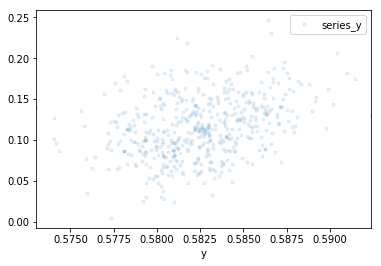

In [198]:
grouped = slice_.groupby('i')
series_approx = grouped['(x-x0)dy/dx'].sum() + grouped['y0'].first()
eval_series = grouped[['y']].quantile(.5)
eval_series['series_y'] = series_approx

eval_series.plot('y', 'series_y', marker = '.', lw = 0, alpha = .1)
# plt.xlim(0, 0.01)
# plt.ylim(0, 0.03)

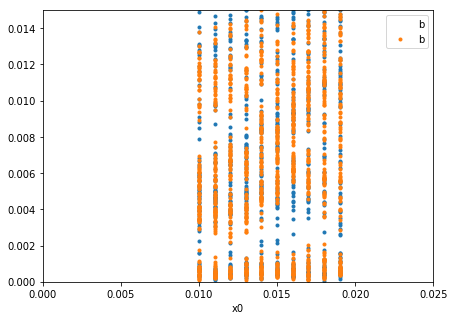

In [354]:
# oo are similar/equal for parabola or linear fits, as they should
# fits1['b2'] = fits2['c']
# fits1.plot('b2', 'b', marker = '.', lw = 0)

df_ = fits1.set_index('Q')[['q', 'x0', 'b']]

# df_['x0_'] = df_['x0'] + np.random.uniform(-0.0003, 0.0003, len(df_))

fig, ax = plt.subplots(1, figsize = (7, 5))
df_.loc[10].plot('x0', 'b', marker = '.', lw = 0, ax = ax)
df_.loc[15].plot('x0', 'b', marker = '.', lw = 0, ax = ax)
ax.set_xlim(0, 0.025)
ax.set_ylim(0, 0.015)
plt.show()

In [331]:
for Q in [10, 15]:
    x = df_.loc[Q]['x0']
    y = df_.loc[Q]['b']
    z = np.polyfit(x, y, 1)
    print(z)

[ 6.11258560e-01 -2.07949449e-04]
[ 5.66583178e-01 -3.52119285e-04]


In [ ]:
def qvars_fits(degree = 1):
    fits = []
    for q in range(Q_):
        df_xy_q = df_xy.loc[df_xy.q == q]
        # points
        x = df_xy_q.var_qi
        y = df_xy_q.y
        # fit
        z = np.polyfit(x, y, degree)
        fits += [z]
    fits = np.array(fits)
    return fits

In [244]:
qvars_fits(1)

array([[0.05847141, 0.00347405],
       [0.05443393, 0.00193246],
       [0.0560431 , 0.00236648],
       [0.04881516, 0.00201882],
       [0.05625421, 0.00229512],
       [0.06245085, 0.00383869],
       [0.04270722, 0.00239089],
       [0.03508963, 0.00175195],
       [0.03251947, 0.00206818],
       [0.03632867, 0.00237791]])

In [205]:
# low var values
df_mp_Q['var_qi'].groupby('q').max().sum()/(Q_**2)

0.0006697514151924629

(0, 0.02)

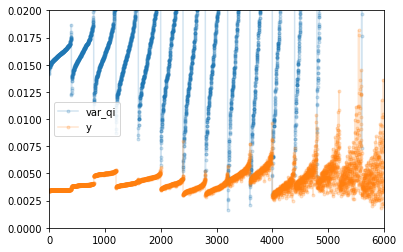

In [221]:
df_xy.sort_values(by = ['q', 'var_qi']).reset_index(drop = True)[['var_qi','y']].plot(marker = '.', alpha = .2)
# plt.yscale('log')
plt.ylim(0, 0.02)

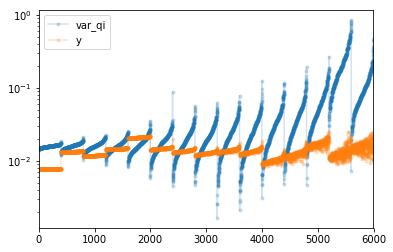

In [167]:
df_xy.sort_values(by = ['q', 'var_qi']).reset_index(drop = True)[['var_qi','y']].plot(marker = '.', alpha = .2)
plt.yscale('log')

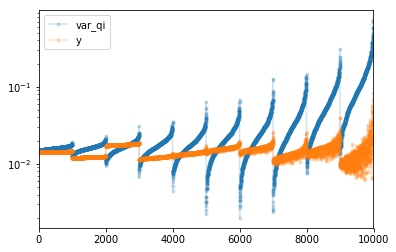

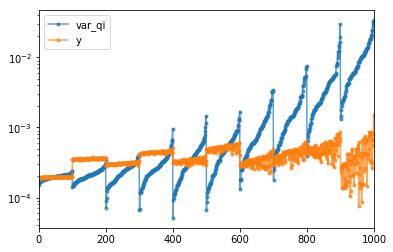

In [232]:
df_xy.sort_values(by = ['q', 'var_qi']).reset_index(drop = True)[['var_qi','y']].plot(marker = '.', alpha = .2)
plt.yscale('log')

In [ ]:
# For all the variables, get the x y's.
# fit poly, get coefficients, store. 
# option to plot.

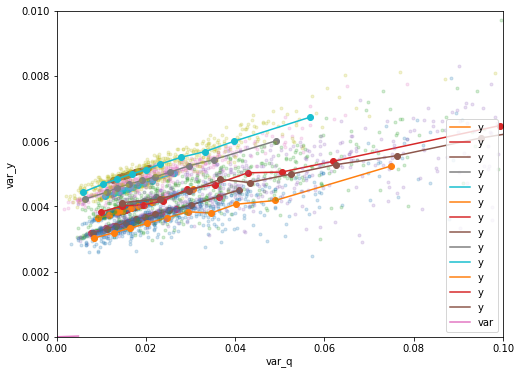

In [217]:
def qvars_fits(degree = 1):
    fits = []
    for q in range(Q_):
        df_xy_q = df_xy.loc[df_xy.q == q]
        # points
        x = df_xy_q.var_qi
        y = df_xy_q.y
        # fit
        z = np.polyfit(x, y, degree)
        fits += [z]
    fits = np.array(fits)
    return fits

fig, ax = plt.subplots(1, figsize = (8, 6))

for q in range(Q_)[:-2]:
    df_xy_q = df_xy.loc[df_xy.q == q]
    ax.plot(df_xy_q.var_qi, df_xy_q.y, '.', alpha = .2)
    bin_mean = df_xy_q.groupby(pd.qcut(df_xy_q.var_qi, 10)).mean()
    bin_mean.plot('var_qi', 'y', marker = 'o', ax = ax)

    # ax.set_xlim(min(x), max(x))
    # ax.set_ylim(min(y), max(y))
    ax.set_xlabel('var_q') 
    ax.set_ylabel('var_y')
    
slice_ = result.loc[result.Q == Q_]
slice_['var'] = slice_['var']#*Q_**2
slice_.plot('var_q', 'var', ax = ax)

ax.set_xlim(0, .1)
ax.set_ylim(0, 0.01)
plt.show()
    # Laplace

## Partial devs

In [188]:
def dx2(x, a, b, c):
    return 2 * a * x + b

def dx(x, a, b):
    return a

In [189]:
partial_devs_1 = np.array([dx(np.median(x), *pars) for pars in qvars_fits(1)])
partial_devs_2 = np.array([dx2(np.median(x), *pars) for pars in qvars_fits(2)])

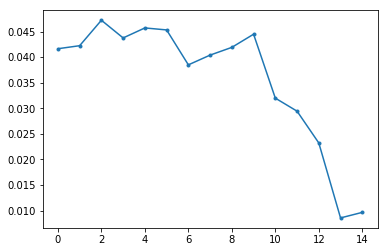

In [190]:
plt.plot(range(Q_), partial_devs_1, marker = '.')
# plt.plot(range(Q_), partial_devs_2, marker = '.')
# plt.plot(range(Q_), fits[:, 0], marker = '.')
# plt.plot(range(Q_), fits[:, 1], marker = '.')
# plt.ylim(0, .07)

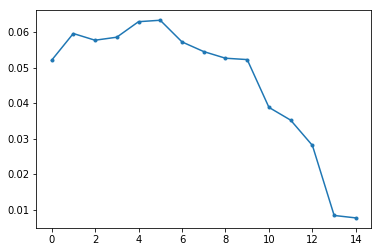

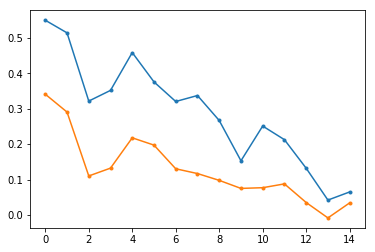

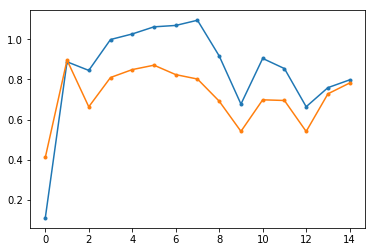

In [245]:
# Gaussian

[0.0863967  0.01296385]
[0.08842814 0.01074267]
[0.09689284 0.01611861]
[0.08432123 0.01063715]
[0.08689185 0.01206402]
[0.09146881 0.01389333]
[0.08071326 0.01385786]
[0.07617694 0.01076438]
[0.04747966 0.01308357]
[0.05237573 0.00767953]


[0.98859968 6.31536187]
[1.0726746  5.50727238]
[1.16982095 8.42172979]
[1.14772977 7.27886601]
[0.99899666 8.59448406]
[ 1.11401587 15.97862462]
[1.3146688  9.78260646]
[1.07650366 8.68275585]
[ 1.18007377 12.5288997 ]
[ 1.09623537 11.0625377 ]


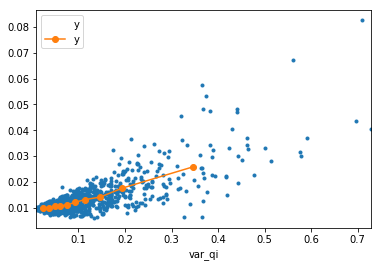

In [252]:
fig, ax = plt.subplots(1)

df_xy_q.plot('var_qi', 'y', marker = '.', lw = 0, ax = ax)
bin_mean = df_xy_q.groupby(pd.qcut(df_xy_q.var_qi, 10)).mean()
bin_mean.plot('var_qi', 'y', marker = 'o', ax = ax)

## Test at sigma = 0
What if the sigma_0 point is set at zero? what are the dependencies? 

What happens with Q and the total? The curvature of the log should have an effect

In [207]:
tot_size = 1e11
M = 50000

result_list = []
for Q in [2, 3, 4, 5, 7, 10, 15, 20, 25, 30]:
    v = []
    for var in np.arange(0, 0.005, 0.0001):
        q_size = np.log10(tot_size/Q)
#         sim_q_size_lin = np.power(10, q_size + np.random.laplace(0, np.sqrt(var), M)/np.sqrt(2))
        sim_q_size_lin = np.power(10, q_size + np.random.normal(0, np.sqrt(var), M))
        sim_log_totals = np.log10(sim_q_size_lin + (1 - 1/Q)*tot_size)
        v += [[var, sim_log_totals.var()]]

    result = pd.DataFrame(np.array(v), columns = ['var_q', 'var'])
    result['Q'] = Q
    result_list += [result]
    
result = pd.concat(result_list)

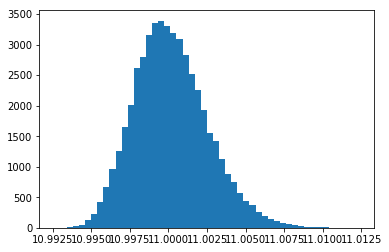

In [208]:
plt.hist(sim_log_totals, 50)
plt.show()

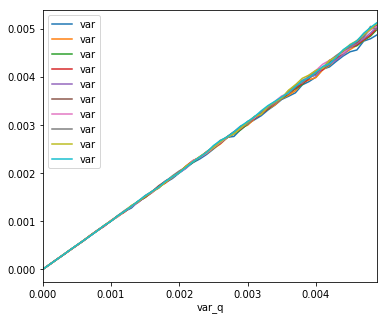

In [209]:
fig, ax = plt.subplots(1, figsize = (6, 5))

for Q in result.Q.unique()[:10]:
    slice_ = result.loc[result.Q == Q]
    slice_['var'] = Q**2*slice_['var']
    slice_.plot('var_q', 'var', ax = ax)

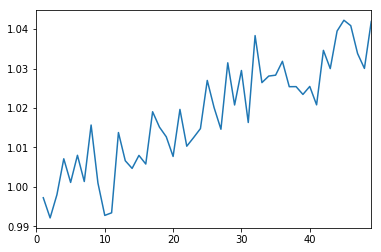

In [162]:
(slice_['var']/slice_['var_q']).plot()